In [1]:
# Ignore warning message
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import python libraries
import math, json
import numpy as np
from numpy import pi
from numpy.fft import fft, rfft
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
# Import Qiskit libraries
import qiskit
import qiskit_aer.noise as noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, Aer, transpile, execute
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.result import marginal_counts

In [4]:
# Load IBMQ account
provider = IBMQ.load_account()

In [5]:
# Set up parameters
Nc = 4  # number of spins: N (= 2, 3, 4, 5)
g = 0.4  # dimensionless Ising coupling: J/h (= 0.2, 0.4, 0.6, 0.8)
eta = 0.3  # dimensionless broadening: \eta/h (= 0.02, 0.1, 0.2, 0.3)
dw = 0.25*eta  # dimensionless unit of discrete frequency: \delta\omega / h
L = 2*math.ceil(7.0/dw)  # count of Fourier components: L
dt = 2*pi/L/dw  # dimensionless unit of discrete time: h \delta t
M = 16  # count of Trotter steps: M
theta = 0.27*pi  # input qubit orientation: \theta
prob = 0.001  # probability for depolarizing noise
shots = 1024  # count of measurement shots

# Define the bit string (00...0) as a reference for thr initial state
s = []
for j in range (Nc):
    s.append('0')
str1 = ""
InQ = str1.join(s)

# Define discrete frequencies
frequency = [(j-L/2)*dw for j in range(L+1)]
with open('data_frequency', 'w') as f:
    f.write(json.dumps(frequency))

# Define quantum circuits
def Circuit_TFIM (Nc,g,theta,M,dt,j):
    
    # Apply y-rotation gates (with clockwise orientation) for basis change
    for n in range (Nc):
        qc.ry(theta, qreg[n])
    
    # Iterate Trotter steps
    for m in range (M):

        # Apply a sequence of unitary gates for time evolution
        for n in range (Nc):
            qc.rx(-2*j*dt/M, qreg[n])
                
        for n in range (Nc-1):
            qc.rzz(-2*g*j*dt/M, qreg[n], qreg[n+1])
                    
    # Apply y-rotation gates (with counterclockwise orientation) for basis change back
    for n in range (Nc):
        qc.ry(-theta, qreg[n])
        
# Define the objective function for curve fitting of the Lorentzian function
def objective (x, a0, a1):
	return a0 + a1 / (x**2 + eta**2)

In [6]:
# Print the start message
print("simulation type: ideal (noiseless)\n...running")

# Initialize array
propagator = []
    
# Loop for Fourier components
for j in range (L):

    # Initialize a set of quantum/classical registers
    qreg = QuantumRegister(Nc, 'q')
    creg = ClassicalRegister(Nc, 'c')
    qc = QuantumCircuit(qreg, creg)
        
    # Apply a sequence of quantum circuits
    Circuit_TFIM (Nc,g,theta,M,dt,j)
        
    # Measure qubits
    qc.measure(qreg, creg)
        
    # Perform quantum simulation on the IBMQ Aer simulator
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, simulator, shots = shots).result()
    counts = result.get_counts()
    
    # Construct a time series of propagators with each component being the probability for (00...0)
    if InQ in counts:
        propagator.append(dt*np.exp(-eta*j*dt)*counts[InQ]/shots)
    else:
        propagator.append(0)
    
    # Print the end message for each step
    print(j+1, end="\r")
    
# Flatten array
propagator = np.ravel(propagator)

# Find the many-body spectral function via discreate fast Fourier transform
spectral_function_0 = np.real(np.fft.ifft(propagator))*L/pi
spectral_function_1 = np.append(spectral_function_0[int(L/2):L], spectral_function_0[0:int(L/2)+1])
spectral_function_2 = [spectral_function_1[j] for j in range(L+1)]

# Truncate the lists in the range [-\eta,\eta]
frequency_truncated = [frequency[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]
spectral_function_truncated = [spectral_function_2[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]

# Curve fitting for the Lorentzian function
popt, _ = curve_fit(objective, frequency_truncated, spectral_function_truncated)
a0, a1 = popt

# Subtract the zeto peak from the manu-body spectral function
spectral_function = [spectral_function_2[j] - a1 / (frequency[j]**2 + eta**2) for j in range(L+1)]

# Save data
with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_ideal' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'w') as f:
    f.write(json.dumps(spectral_function))
    
# Print the end message
print("...completed")

simulation type: ideal (noiseless)
...running
...completed


In [7]:
# Print the start message
print("simulation type: 2-qubit depolarizing noise\n...running")

# Build the custom noise model for 2-qubit depolarizing noise
noise_model = noise.NoiseModel()
error_gate = noise.depolarizing_error(prob, 2)
noise_model.add_all_qubit_quantum_error(error_gate, ['rzz'])
basis_gates = noise_model.basis_gates
        
# Initialize array
propagator = []
    
# Loop for Fourier components
for j in range (L):

    # Initialize a set of quantum/classical registers
    qreg = QuantumRegister(Nc, 'q')
    creg = ClassicalRegister(Nc, 'c')
    qc = QuantumCircuit(qreg, creg)
        
    # Apply a sequence of quantum circuits
    Circuit_TFIM (Nc,g,theta,M,dt,j)
        
    # Measure qubits
    qc.measure(qreg, creg)
        
    # Perform quantum simulation on the IBMQ Aer simulator
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, simulator, noise_model = noise_model, basis_gates = basis_gates, shots = shots).result()
    counts = result.get_counts()
    
    # Construct a time series of propagators with each component being the probability for (00...0)
    if InQ in counts:
        propagator.append(dt*np.exp(-eta*j*dt)*counts[InQ]/shots)
    else:
        propagator.append(0)
    
    # Print the end message for each step
    print(j+1, end="\r")
    
# Flatten array
propagator = np.ravel(propagator)

# Find the many-body spectral function via discreate fast Fourier transform
spectral_function_0 = np.real(np.fft.ifft(propagator))*L/pi
spectral_function_1 = np.append(spectral_function_0[int(L/2):L], spectral_function_0[0:int(L/2)+1])
spectral_function_2 = [spectral_function_1[j] for j in range(L+1)]

# Truncate the lists in the range [-\eta,\eta]
frequency_truncated = [frequency[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]
spectral_function_truncated = [spectral_function_2[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]

# Curve fitting for the Lorentzian function
popt, _ = curve_fit(objective, frequency_truncated, spectral_function_truncated)
a0, a1 = popt

# Subtract the zeto peak from the manu-body spectral function
spectral_function = [spectral_function_2[j] - a1 / (frequency[j]**2 + eta**2) for j in range(L+1)]

# Save data
with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_depolarizing' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'w') as f:
    f.write(json.dumps(spectral_function))
    
# Print the end message
print("...completed")

simulation type: 2-qubit depolarizing noise
...running
...completed


In [8]:
# Print the start message
print("simulation type: device backend noise\n...running")

# Build noise model from backend calibration data
backend = provider.get_backend("ibmq_manila")
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Initialize array
propagator = []
    
# Loop for Fourier components
for j in range (L):

    # Initialize a set of quantum/classical registers
    qreg = QuantumRegister(Nc, 'q')
    creg = ClassicalRegister(Nc, 'c')
    qc = QuantumCircuit(qreg, creg)
        
    # Apply a sequence of quantum circuits
    Circuit_TFIM (Nc,g,theta,M,dt,j)
        
    # Measure qubits
    qc.measure(qreg, creg)
        
    # Perform quantum simulation on the IBMQ Aer simulator
    simulator = Aer.get_backend('qasm_simulator')
    qc_trans = transpile(qc, backend, optimization_level = 1, initial_layout = [k for k in range(Nc)])
    result = execute(qc_trans, simulator, noise_model = noise_model, coupling_map = coupling_map,\
                     basis_gates = basis_gates, shots = shots).result()    
    counts = result.get_counts()
    
    # Construct a time series of propagators with each component being the probability for (00...0)
    if InQ in counts:
        propagator.append(dt*np.exp(-eta*j*dt)*counts[InQ]/shots)
    else:
        propagator.append(0)
    
    # Print the end message for each step
    print(j+1, end="\r")
    
# Flatten array
propagator = np.ravel(propagator)

# Find the many-body spectral function via discreate fast Fourier transform
spectral_function_0 = np.real(np.fft.ifft(propagator))*L/pi
spectral_function_1 = np.append(spectral_function_0[int(L/2):L], spectral_function_0[0:int(L/2)+1])
spectral_function_2 = [spectral_function_1[j] for j in range(L+1)]

# Truncate the lists in the range [-\eta,\eta]
frequency_truncated = [frequency[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]
spectral_function_truncated = [spectral_function_2[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]

# Curve fitting for the Lorentzian function
popt, _ = curve_fit(objective, frequency_truncated, spectral_function_truncated)
a0, a1 = popt

# Subtract the zeto peak from the manu-body spectral function
spectral_function = [spectral_function_2[j] - a1 / (frequency[j]**2 + eta**2) for j in range(L+1)]

# Save data
with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_noisemodel' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'w') as f:
    f.write(json.dumps(spectral_function))
    
# Print the end message
print("...completed")

simulation type: device backend noise
...running
...completed


In [9]:
# Print the start message
print("simulation type: real device\n...running")

# Initialize a set of quantum/classical registers
qreg = QuantumRegister(Nc, 'q')
creg = ClassicalRegister(Nc*L, 'c')
qc = QuantumCircuit(qreg, creg)
        
# Loop for Fourier components
for j in range (L):

    # Reset quantum registers
    qc.reset(qreg)
        
    # Apply a sequence of quantum circuits
    Circuit_TFIM (Nc,g,theta,M,dt,j)
        
    # Perform mid-circuit measurement
    assign_qubits = [Nc*j + k for k in range(Nc)]
    qc.measure(qreg, assign_qubits)

# Perform quantum simulation on the IBMQ device
backend = provider.get_backend("ibmq_manila")
qc_trans = transpile(qc, backend, optimization_level = 1, initial_layout = [k for k in range(Nc)])
result = execute(qc_trans, backend, shots = shots).result()

# Initialize array
propagator = []
    
# Loop for Fourier components
for j in range (L):
    
    # Obtain marginal measurement counts from mid-circuit measurement
    assign_qubits = [Nc*j + k for k in range(Nc)]
    counts = marginal_counts(result, indices = assign_qubits).get_counts()
    
    # Construct a time series of propagators with each component being the probability for (00...0)
    if InQ in counts:
        propagator.append(dt*np.exp(-eta*j*dt)*counts[InQ]/shots)
    else:
        propagator.append(0)
    
    # Print the end message for each step
    print(j+1, end="\r")
    
# Flatten array
propagator = np.ravel(propagator)

# Find the many-body spectral function via discreate fast Fourier transform
spectral_function_0 = np.real(np.fft.ifft(propagator))*L/pi
spectral_function_1 = np.append(spectral_function_0[int(L/2):L], spectral_function_0[0:int(L/2)+1])
spectral_function_2 = [spectral_function_1[j] for j in range(L+1)]

# Truncate the lists in the range [-\eta,\eta]
frequency_truncated = [frequency[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]
spectral_function_truncated = [spectral_function_2[j] for j in range(math.ceil(L/2-eta/dw),math.ceil(L/2+1+eta/dw))]

# Curve fitting for the Lorentzian function
popt, _ = curve_fit(objective, frequency_truncated, spectral_function_truncated)
a0, a1 = popt

# Subtract the zeto peak from the manu-body spectral function
spectral_function = [spectral_function_2[j] - a1 / (frequency[j]**2 + eta**2) for j in range(L+1)]

# Save data
with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_realdevice' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'w') as f:
    f.write(json.dumps(spectral_function))
    
# Print the end message
print("...completed")

simulation type: real device
...running
...completed


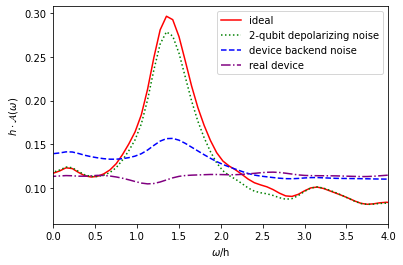

In [10]:
# Load data for frequency
with open('data_frequency' , 'r') as f:
    frequency = json.loads(f.read())
    
# Load data for spectral function
with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_ideal' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'r') as f:
    spectral_function_ideal = json.loads(f.read())
    
with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_depolarizing' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'r') as f:
    spectral_function_depolarizing = json.loads(f.read())

with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_noisemodel' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'r') as f:
    spectral_function_noisemodel = json.loads(f.read())
    
with open('data_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s_realdevice' % 
        (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
         int(M),int(theta/pi),str(theta/pi).split(".")[-1]), 'r') as f:
    spectral_function_realdevice = json.loads(f.read())
    
# Plot simulation data
plt.plot(frequency, spectral_function_ideal, label = "ideal", color = 'red', ls = '-')
plt.plot(frequency, spectral_function_depolarizing, label = "2-qubit depolarizing noise", color = 'green', ls = ':')
plt.plot(frequency, spectral_function_noisemodel, label = "device backend noise", color = 'blue', ls = '--')
plt.plot(frequency, spectral_function_realdevice, label = "real device", color = 'purple', ls = '-.')
plt.xlim([0, 4])
plt.xlabel("$\omega$/h")
plt.ylabel("$h\cdot\mathcal{A}(\omega)$")
plt.legend()
plt.savefig('Fig_spectral_function_N%s_g%sp%s_eta%sp%s_M%s_theta%sp%s.pdf' % 
            (int(Nc),int(g),str(g).split(".")[-1],int(eta),str(eta).split(".")[-1],\
             int(M),int(theta/pi),str(theta/pi).split(".")[-1]))